## Data Cleaning and Preprocessing

In [1]:
# Importing required libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import math

In [2]:
# Function for extracting feature information like datatype, shape and feature name 
def extract_feature_info(tfrecord_file):
    raw_dataset = tf.data.TFRecordDataset([tfrecord_file])
    for raw_record in raw_dataset.take(1):
        example = tf.train.Example()
        example.ParseFromString(raw_record.numpy())
        feature_info = {}
        for key, feature in example.features.feature.items():
            if feature.bytes_list.value:
                feature_info[key] = {"type": "string", "shape": []}
            elif feature.float_list.value:
                vals = feature.float_list.value
                if len(vals) == 1:
                    shape = []
                else:
                    shape = [len(vals)]
                feature_info[key] = {"type": "float", "shape": shape}
            elif feature.int64_list.value:
                vals = feature.int64_list.value
                if len(vals) == 1:
                    shape = []
                else:
                    shape = [len(vals)]
                feature_info[key] = {"type": "int64", "shape": shape}
        print(f"Auto-detected feature info from '{tfrecord_file}':")
        print(feature_info)
        return feature_info
    return {}

In [3]:
# Checking if we are accessing correct directory or not
tfrecord_dir = "/kaggle/input/next-day-wildfire-dataset/kaggle-next-day-wildfire-spread/"
tfrecord_files = sorted(glob.glob(os.path.join(tfrecord_dir, "*.tfrecord")))
if not tfrecord_files:
    print(f"No TFRecord files found in directory: {tfrecord_dir}")
print("Found TFRecord files:")
for f in tfrecord_files:
    print(f)

Found TFRecord files:
/kaggle/input/next-day-wildfire-dataset/kaggle-next-day-wildfire-spread/next_day_wildfire_spread_eval_00.tfrecord
/kaggle/input/next-day-wildfire-dataset/kaggle-next-day-wildfire-spread/next_day_wildfire_spread_eval_01.tfrecord
/kaggle/input/next-day-wildfire-dataset/kaggle-next-day-wildfire-spread/next_day_wildfire_spread_test_00.tfrecord
/kaggle/input/next-day-wildfire-dataset/kaggle-next-day-wildfire-spread/next_day_wildfire_spread_test_01.tfrecord
/kaggle/input/next-day-wildfire-dataset/kaggle-next-day-wildfire-spread/next_day_wildfire_spread_train_00.tfrecord
/kaggle/input/next-day-wildfire-dataset/kaggle-next-day-wildfire-spread/next_day_wildfire_spread_train_01.tfrecord
/kaggle/input/next-day-wildfire-dataset/kaggle-next-day-wildfire-spread/next_day_wildfire_spread_train_02.tfrecord
/kaggle/input/next-day-wildfire-dataset/kaggle-next-day-wildfire-spread/next_day_wildfire_spread_train_03.tfrecord
/kaggle/input/next-day-wildfire-dataset/kaggle-next-day-wildfi

In [4]:
# Loading and extracting feature from 1st sample
first_file = tfrecord_files[0]
feature_info = extract_feature_info(first_file)
if not feature_info:
    print("No feature info detected")

Auto-detected feature info from '/kaggle/input/next-day-wildfire-dataset/kaggle-next-day-wildfire-spread/next_day_wildfire_spread_eval_00.tfrecord':
{'th': {'type': 'float', 'shape': [4096]}, 'population': {'type': 'float', 'shape': [4096]}, 'tmmn': {'type': 'float', 'shape': [4096]}, 'sph': {'type': 'float', 'shape': [4096]}, 'erc': {'type': 'float', 'shape': [4096]}, 'tmmx': {'type': 'float', 'shape': [4096]}, 'pr': {'type': 'float', 'shape': [4096]}, 'pdsi': {'type': 'float', 'shape': [4096]}, 'elevation': {'type': 'float', 'shape': [4096]}, 'vs': {'type': 'float', 'shape': [4096]}, 'NDVI': {'type': 'float', 'shape': [4096]}, 'PrevFireMask': {'type': 'float', 'shape': [4096]}, 'FireMask': {'type': 'float', 'shape': [4096]}}


In [5]:
# Function for parsing a single TFRecord sample using the detected feature information
def parse_record(serialized_example, feature_info):
    feature_description = {}
    for key, info in feature_info.items():
        if info["type"] == "string":
            feature_description[key] = tf.io.FixedLenFeature([], tf.string)
        elif info["type"] == "float":
            if info["shape"]:
                feature_description[key] = tf.io.FixedLenFeature(info["shape"], tf.float32)
            else:
                feature_description[key] = tf.io.FixedLenFeature([], tf.float32)
        elif info["type"] == "int64":
            if info["shape"]:
                feature_description[key] = tf.io.FixedLenFeature(info["shape"], tf.int64)
            else:
                feature_description[key] = tf.io.FixedLenFeature([], tf.int64)
    return tf.io.parse_single_example(serialized_example, feature_description)

# Creating a TFRecordDataset from all TFRecord files
raw_dataset = tf.data.TFRecordDataset(tfrecord_files)

# Mapping each record to a parsed sample
parsed_dataset = raw_dataset.map(lambda x: parse_record(x, feature_info))

# Displaying top 5 samples to understand the data
print("Displaying first 5 records:")
for i, record in enumerate(parsed_dataset.take(5)):
    print(f"\nRecord {i}:")
    for key, value in record.items():
        print(f"{key}: {value.numpy()}")

Displaying first 5 records:

Record 0:
FireMask: [0. 0. 0. ... 0. 0. 0.]
NDVI: [5567. 5664. 5379. ... 5162. 4169. 4169.]
PrevFireMask: [0. 0. 0. ... 0. 0. 0.]
elevation: [ 88.  86.  87. ... 109. 106. 102.]
erc: [14.17904  14.182354 14.188672 ... 13.71543  13.723562 13.742153]
pdsi: [2.6782818 2.6691072 2.6552923 ... 3.7715657 3.766903  3.7593427]
population: [ 1.4766088  1.4766091  1.476609  ... 39.254234  39.430153  39.430145 ]
pr: [6.458093  6.486462  6.5059075 ... 5.9699697 5.98822   6.0034757]
sph: [0.00907956 0.00908028 0.00908092 ... 0.00797545 0.00797619 0.0079763 ]
th: [144.67245 144.66702 144.63695 ... 153.06473 152.71217 152.41515]
tmmn: [279.37222 279.37598 279.38028 ... 277.73108 277.74533 277.75964]
tmmx: [293.84445 293.85745 293.8711  ... 292.26135 292.27383 292.28552]
vs: [3.7468874 3.7470345 3.7470841 ... 3.9530666 3.9572198 3.9624588]

Record 1:
FireMask: [0. 0. 0. ... 0. 0. 0.]
NDVI: [ 4323.  3966.  3801. ...  2439. -3784. -3603.]
PrevFireMask: [0. 0. 0. ... 0. 0. 0.]

In [6]:
# Function to load all the samples
def load_samples_from_tfrecord(tfrecord_files, feature_info):
    samples = []
    for tfrecord_file in tfrecord_files:
        ds = tf.data.TFRecordDataset([tfrecord_file])
        ds = ds.map(lambda x: parse_record(x, feature_info))
        for example in ds:
            ex_dict = {key: example[key].numpy() for key in example.keys()}
            samples.append(ex_dict)
    return samples

print("Loading samples from TFRecord files")
all_samples = load_samples_from_tfrecord(tfrecord_files, feature_info)
print(f"Loaded {len(all_samples)} samples.")

Loading samples from TFRecord files
Loaded 18545 samples.


In [7]:
# Loading 10 samples for visualization
parsed_samples = list(parsed_dataset.take(10))
print(f"Loaded {len(parsed_samples)} samples for visualization.")

Loaded 10 samples for visualization.


In [8]:
# Resahpe 1D array to 2D if the array's size is a perfect square
def try_reshape(array):
    n = array.size
    side = int(math.sqrt(n))
    if side * side == n:
        return array.reshape(side, side), (side, side)
    return array, None

## Exploratory Data Analysis

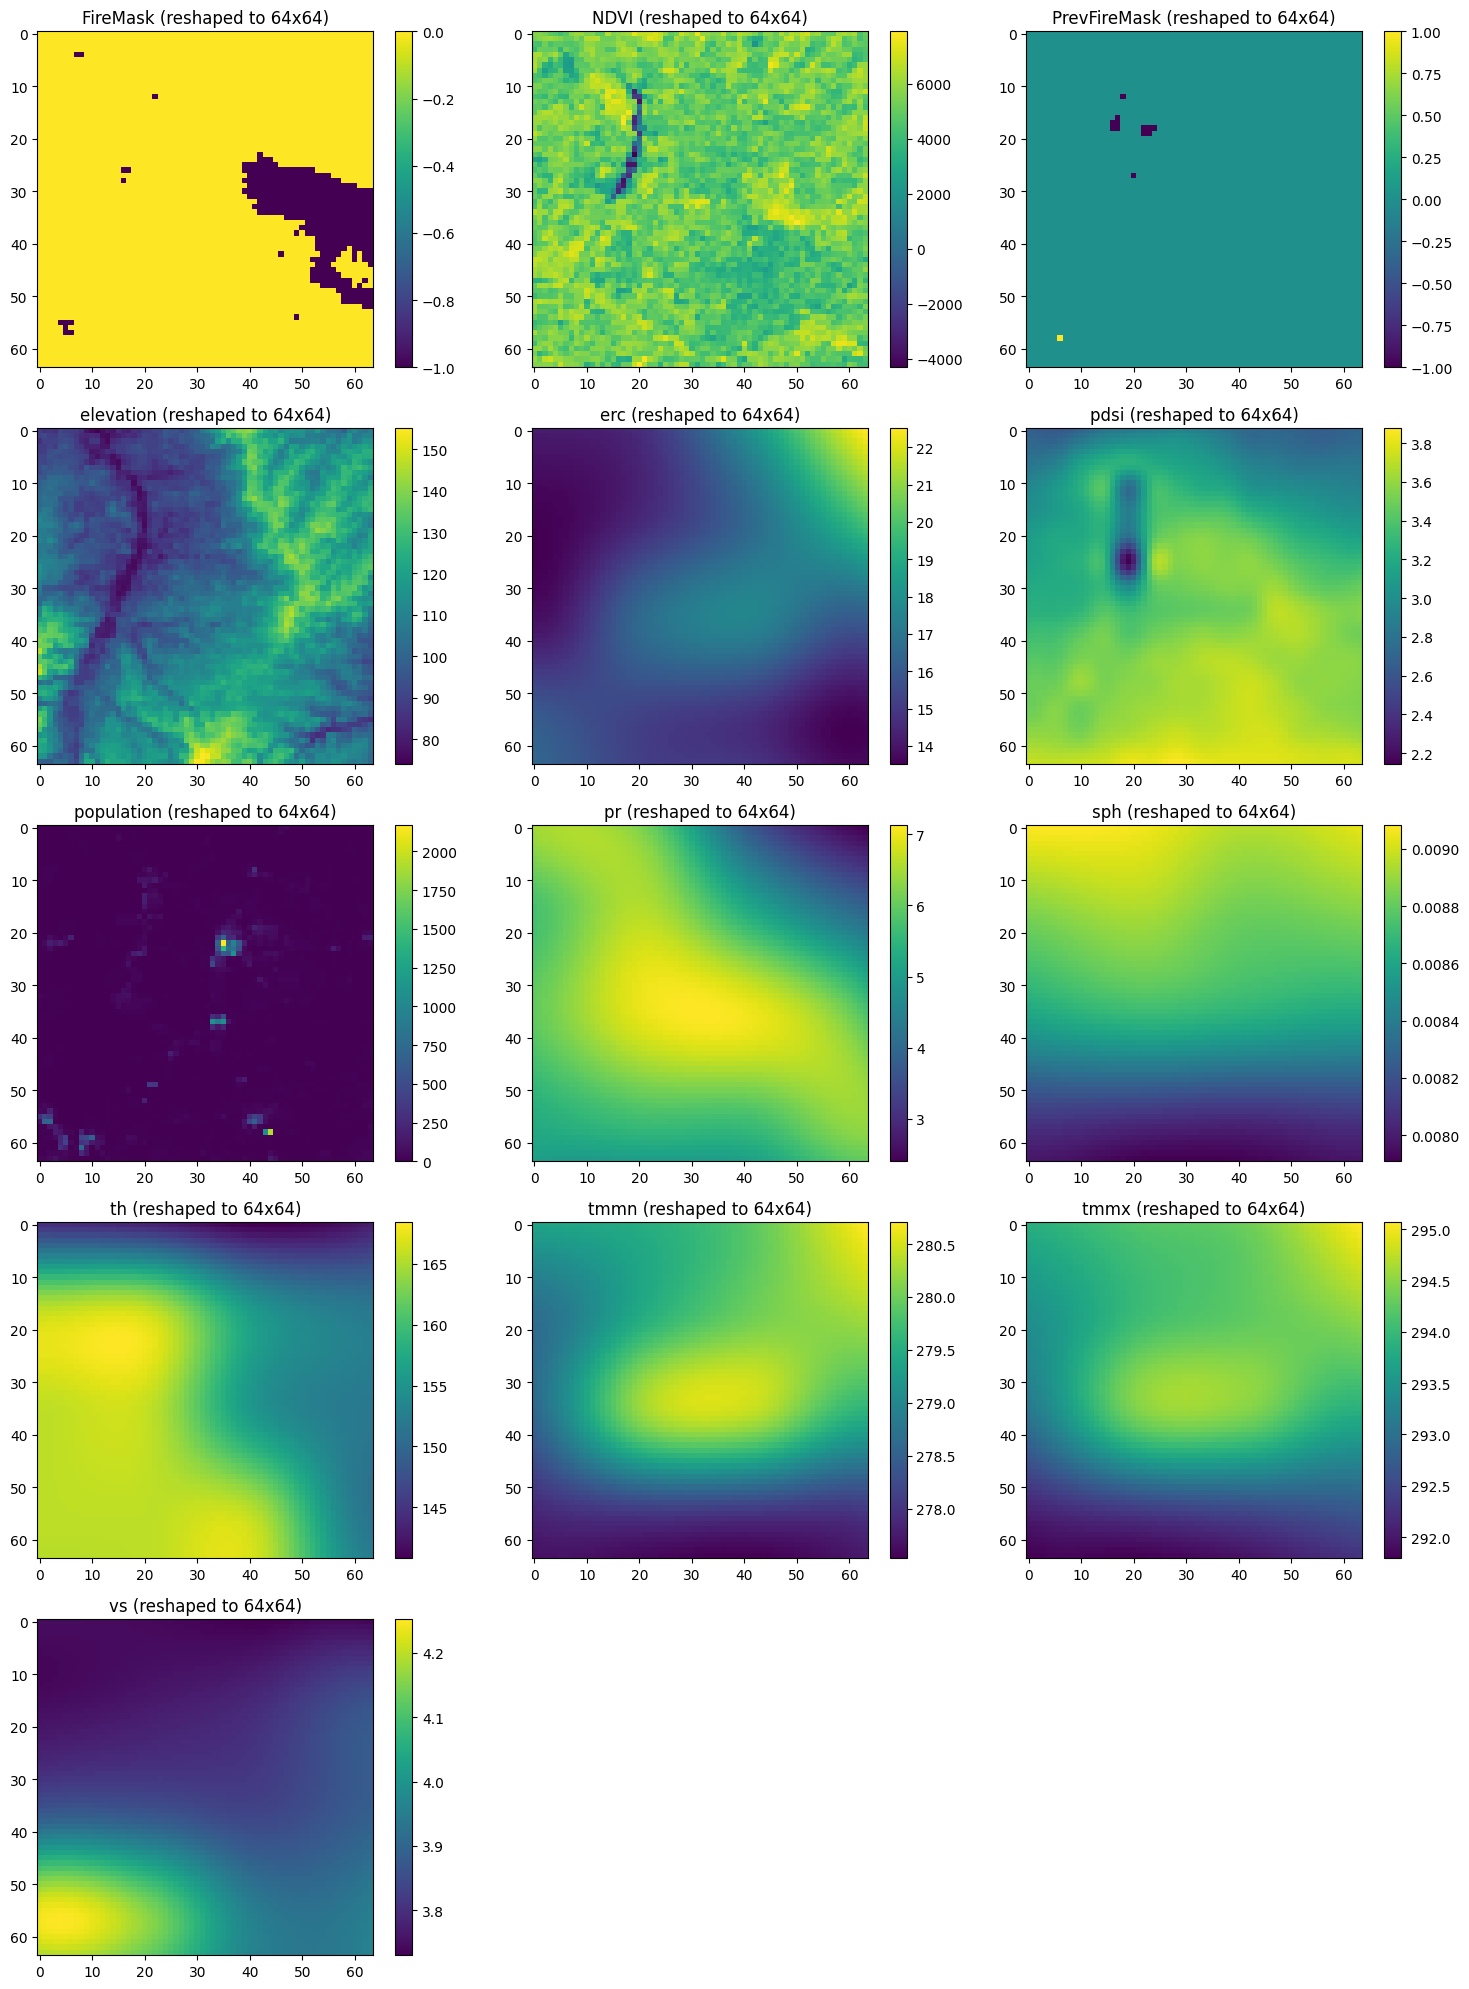

In [10]:
# Visualize features of the 1st sample
import math

sample = parsed_samples[0]

# Creating a list of feature items from the 1st sample
features = list(sample.items())
n_features = len(features)
ncols = 3
nrows = math.ceil(n_features / ncols)

fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 5, nrows * 4))
axes = axes.flatten()

for i, (key, value) in enumerate(features):
    array = value.numpy()
    reshaped, shape = try_reshape(array)
    ax = axes[i]
    if shape:
        im = ax.imshow(reshaped, cmap='viridis')
        ax.set_title(f"{key} (reshaped to {shape[0]}x{shape[1]})")
        fig.colorbar(im, ax=ax)
    else:
        ax.hist(array, bins=30)
        ax.set_title(f"{key} Distribution")
        ax.set_xlabel(key)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [11]:
# Computed statistics across samples
feature_stats = {}
for key in sample.keys():
    # Concatenate the flattened values of the feature from all samples.
    all_values = np.concatenate([ex[key].numpy().flatten() for ex in parsed_samples])
    feature_stats[key] = {
        "mean": np.mean(all_values),
        "std": np.std(all_values),
        "min": np.min(all_values),
        "max": np.max(all_values)
    }
print("Feature Summary Statistics:")
for key, stats in feature_stats.items():
    print(f"{key}: Mean={stats['mean']:.2f}, Std={stats['std']:.2f}, Min={stats['min']:.2f}, Max={stats['max']:.2f}")

Feature Summary Statistics:
FireMask: Mean=-0.24, Std=0.43, Min=-1.00, Max=1.00
NDVI: Mean=5157.14, Std=1883.21, Min=-5968.00, Max=9765.00
PrevFireMask: Mean=-0.04, Std=0.20, Min=-1.00, Max=1.00
elevation: Mean=451.54, Std=397.64, Min=19.00, Max=3110.00
erc: Mean=33.16, Std=17.10, Min=-0.11, Max=73.67
pdsi: Mean=-1.05, Std=2.52, Min=-4.80, Max=3.88
population: Mean=15.52, Std=103.11, Min=0.00, Max=2684.75
pr: Mean=4.69, Std=8.23, Min=-0.03, Max=35.74
sph: Mean=0.01, Std=0.00, Min=0.00, Max=0.01
th: Mean=180.44, Std=53.01, Min=70.05, Max=254.39
tmmn: Mean=281.56, Std=3.79, Min=273.14, Max=286.70
tmmx: Mean=295.96, Std=6.37, Min=277.03, Max=305.97
vs: Mean=4.61, Std=2.45, Min=1.68, Max=9.77


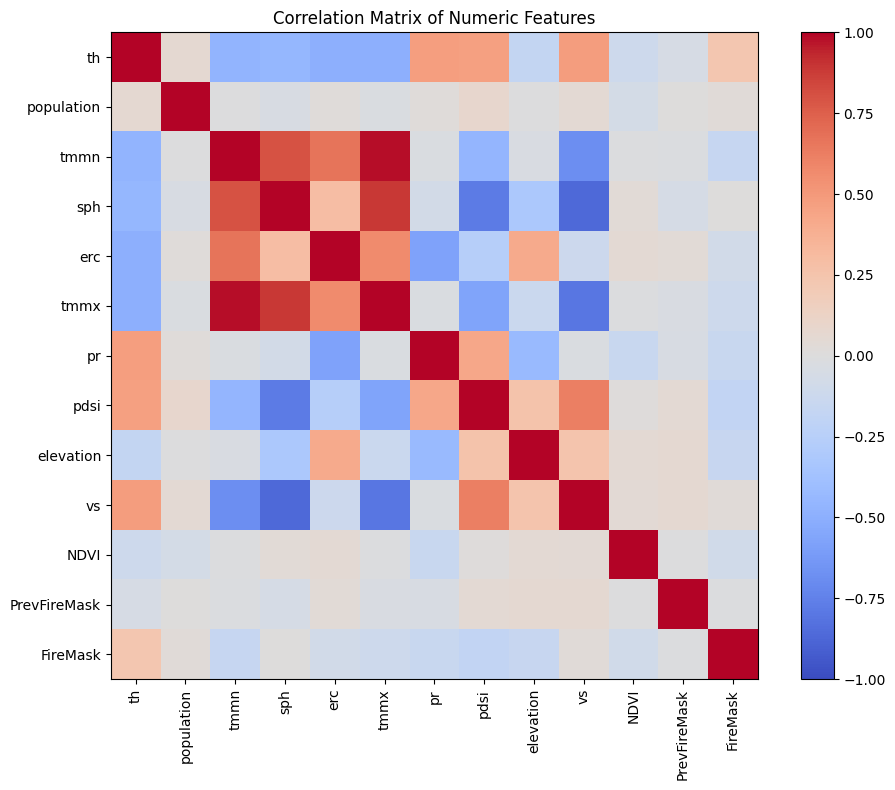

In [12]:
# Correlation Matrix
numeric_keys = [key for key, info in feature_info.items() if info["type"] in ["float", "int64"]]
feature_vectors = {}
for key in numeric_keys:
    feature_vectors[key] = sample[key].numpy().flatten()

# Stack the feature vectors to create a matrix (each row corresponds to one feature).
feature_matrix = np.array([vec for vec in feature_vectors.values()])
corr_matrix = np.corrcoef(feature_matrix)

plt.figure(figsize=(10,8))
im = plt.imshow(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar(im)
plt.xticks(ticks=np.arange(len(numeric_keys)), labels=numeric_keys, rotation=90)
plt.yticks(ticks=np.arange(len(numeric_keys)), labels=numeric_keys)
plt.title("Correlation Matrix of Numeric Features")
plt.tight_layout()
plt.show()

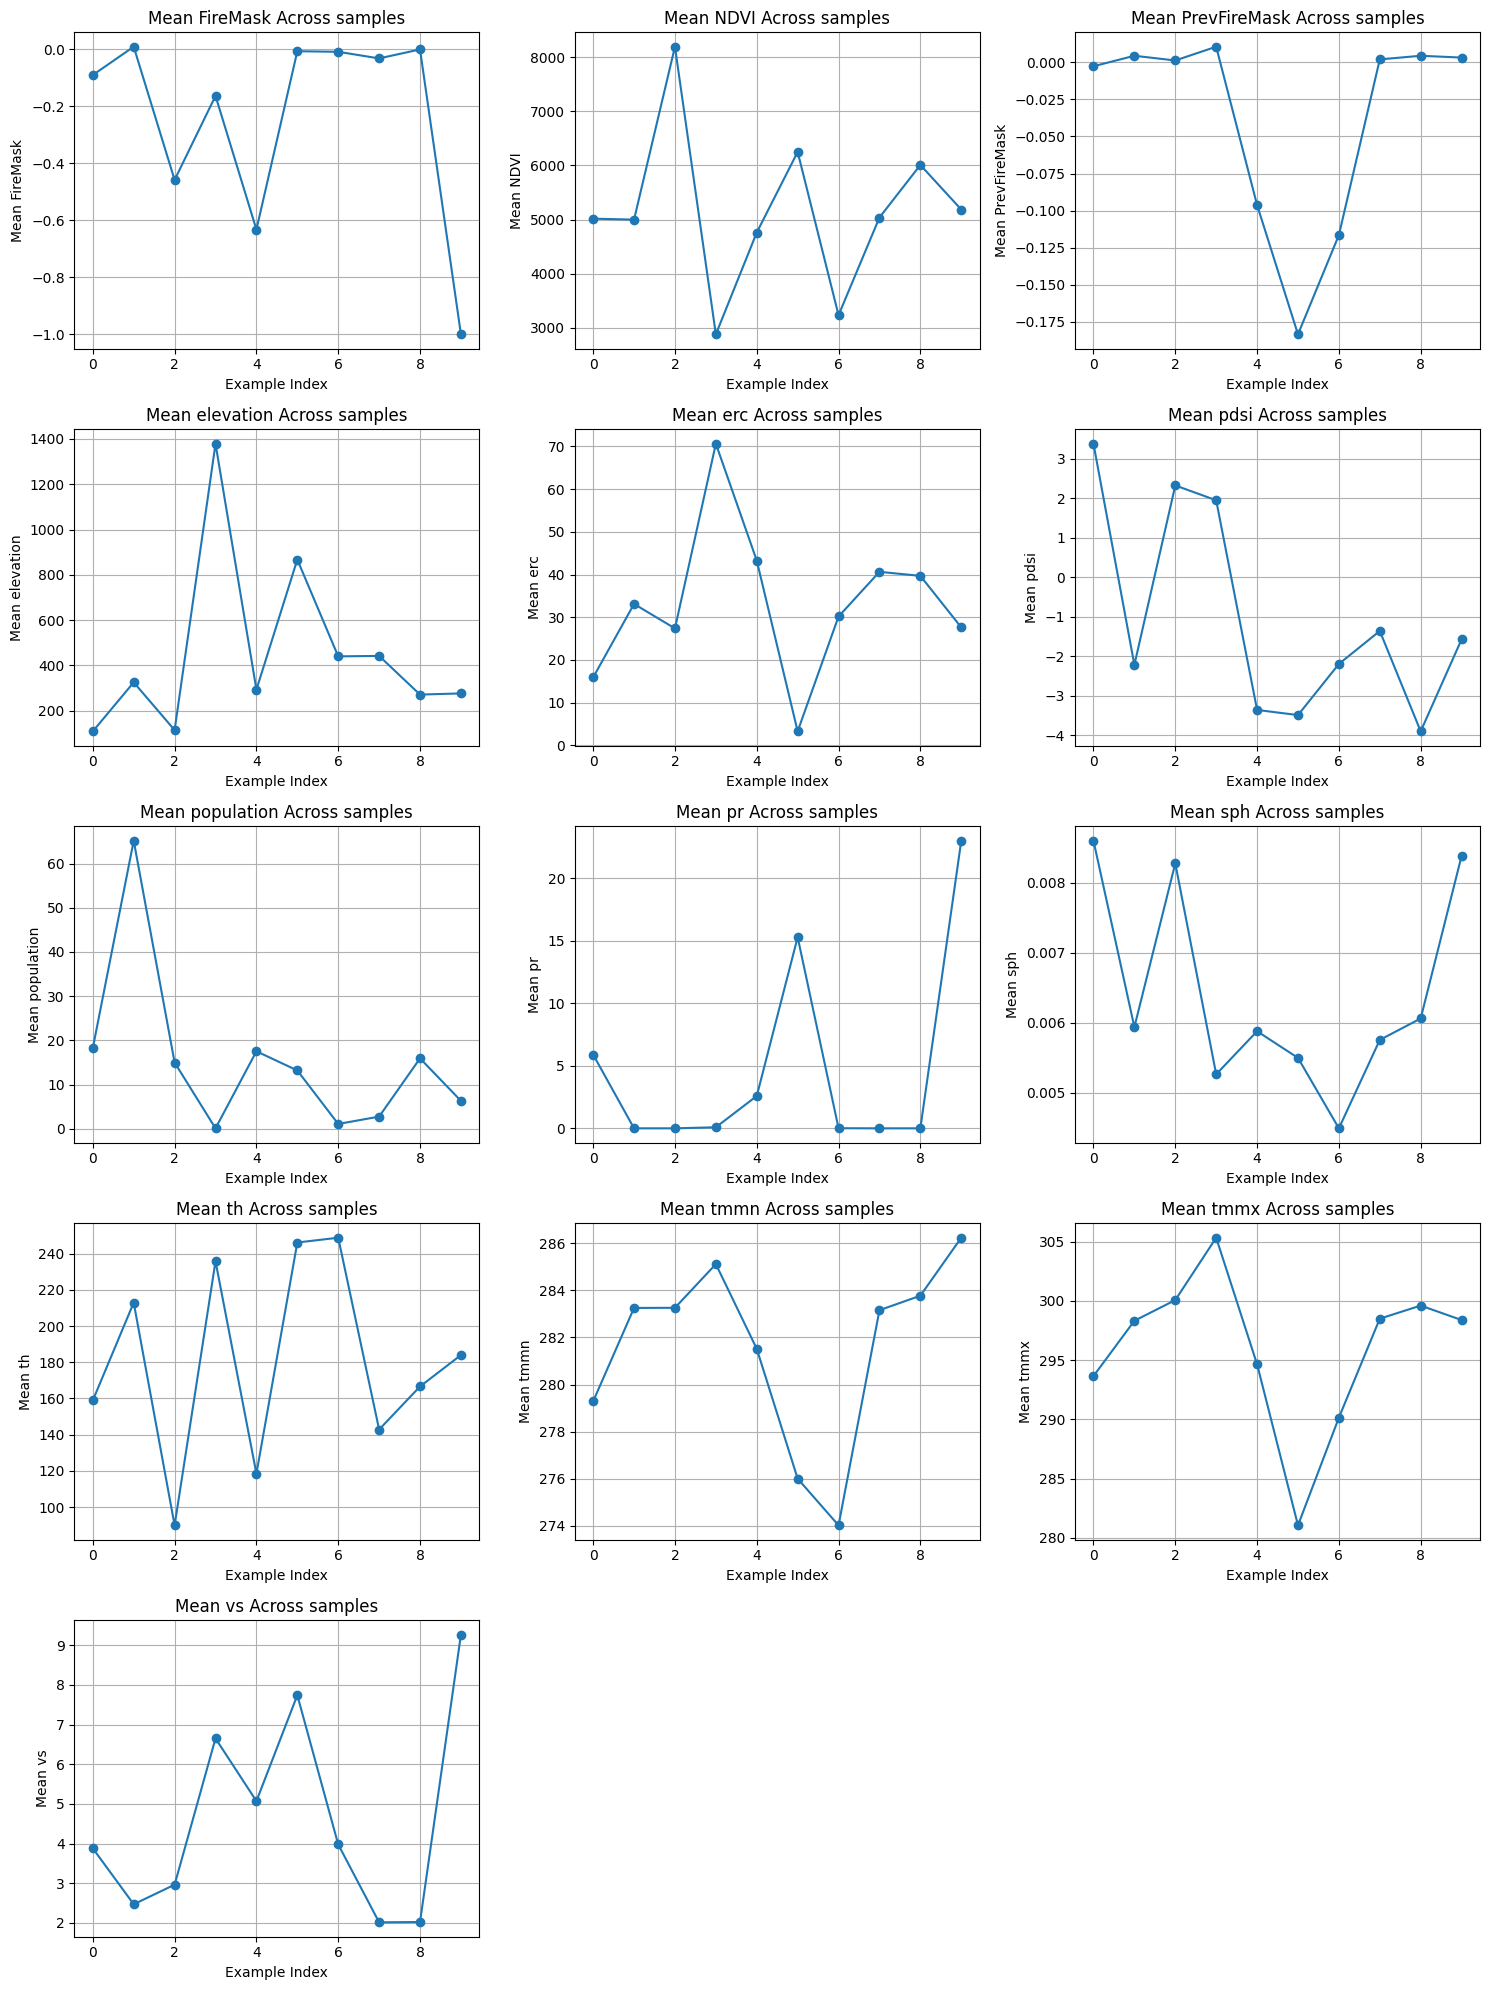

In [13]:
# Plotting time series for each feature
features = list(sample.keys())
n_features = len(features)
ncols = 3
nrows = math.ceil(n_features / ncols)

fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 5, nrows * 4))
axes = axes.flatten()

for i, feature in enumerate(features):
    time_series = []
    for ex in parsed_samples:
        values = ex[feature].numpy().flatten()
        time_series.append(np.mean(values))
    ax = axes[i]
    ax.plot(time_series, marker='o')
    ax.set_title(f"Mean {feature} Across samples")
    ax.set_xlabel("Example Index")
    ax.set_ylabel(f"Mean {feature}")
    ax.grid(True)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## Model 1

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split

In [15]:
# Defining dataset loader
class WildfireDataset(Dataset):
    def __init__(self, samples, grid_size=64, input_keys=None, transform=None):
        self.samples = samples
        self.grid_size = grid_size
        self.transform = transform
        if input_keys is None:
            self.input_keys = [key for key in feature_info.keys() if key != "FireMask"]
        else:
            self.input_keys = input_keys

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        record = self.samples[idx]
        inputs = []
        for key in self.input_keys:
            # Converting the list to numpy array and reshaped to (grid_size, grid_size)
            arr = np.array(record[key], dtype=np.float32)
            arr = arr.reshape((self.grid_size, self.grid_size))
            arr = np.expand_dims(arr, axis=0)
            inputs.append(arr)
        x = np.concatenate(inputs, axis=0)
        
        # Processing target FireMask
        target = np.array(record["FireMask"], dtype=np.float32)
        target = target.reshape((self.grid_size, self.grid_size))
        # Converting to binary mask i.e. fire if value > 0 else no fire
        target = (target > 0).astype(np.float32)
        target = np.expand_dims(target, axis=0)
        
        # Converting into tensors
        x = torch.tensor(x)
        target = torch.tensor(target)
        
        if self.transform:
            x = self.transform(x)
            
        return x, target

full_dataset = WildfireDataset(all_samples, grid_size=64)

In [17]:
# Data Augmentation
class RandomFlipRotate(object):
    def __init__(self, p=0.5):
        self.p = p
        
    def __call__(self, x):
        # Random horizontal flip
        if np.random.rand() < self.p:
            x = torch.flip(x, dims=[2])
        # Random vertical flip
        if np.random.rand() < self.p:
            x = torch.flip(x, dims=[1])
        # Random 90 degree rotation
        k = np.random.randint(0, 4)
        x = torch.rot90(x, k, dims=[1,2])
        return x

transform = RandomFlipRotate(p=0.5)

In [18]:
# Splitting into train, validation and test
train_val_idx, test_idx = train_test_split(list(range(len(full_dataset))), test_size=0.15, random_state=42)
train_idx, val_idx = train_test_split(train_val_idx, test_size=(0.15/0.85), random_state=42)

train_dataset = Subset(full_dataset, train_idx)
val_dataset = Subset(full_dataset, val_idx)
test_dataset = Subset(full_dataset, test_idx)

# Applying data augmentation only to training data
train_dataset.dataset.transform = transform

batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

## Model Architecture

In [19]:
# Defining attention block
class AttentionBlock(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super(AttentionBlock, self).__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )
        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi

# Defining attention U-Net model
class AttUNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(AttUNet, self).__init__()
        # Encoder
        self.enc1 = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.pool1 = nn.MaxPool2d(2)
        
        self.enc2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.pool2 = nn.MaxPool2d(2)
        
        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        
        # Decoder
        self.up2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.att2 = AttentionBlock(F_g=64, F_l=64, F_int=32)
        self.dec2 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        
        self.up1 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.att1 = AttentionBlock(F_g=32, F_l=32, F_int=16)
        self.dec1 = nn.Sequential(
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        
        self.out_conv = nn.Conv2d(32, out_channels, kernel_size=1)
        
    def forward(self, x):
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool1(enc1))    
        bottleneck = self.bottleneck(self.pool2(enc2))
        
        dec2 = self.up2(bottleneck)           
        enc2_att = self.att2(dec2, enc2)       
        dec2 = torch.cat([dec2, enc2_att], dim=1)  
        dec2 = self.dec2(dec2)                
        
        dec1 = self.up1(dec2)                
        enc1_att = self.att1(dec1, enc1)       
        dec1 = torch.cat([dec1, enc1_att], dim=1) 
        dec1 = self.dec1(dec1)                
        
        out = self.out_conv(dec1)             
        return torch.sigmoid(out)             

in_channels = len([key for key in feature_info.keys() if key != "FireMask"])
model = AttUNet(in_channels=in_channels, out_channels=1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

AttUNet(
  (enc1): Sequential(
    (0): Conv2d(12, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bottleneck): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (up2): ConvTranspose2d(128, 64, kernel_size=(2, 2), stride=(2, 2))
  (att2): AttentionBlock(
    (W_g): Sequenti

In [20]:
from torchinfo import summary
summary(model, input_size=(1, in_channels, 64, 64))

Layer (type:depth-idx)                   Output Shape              Param #
AttUNet                                  [1, 1, 64, 64]            --
├─Sequential: 1-1                        [1, 32, 64, 64]           --
│    └─Conv2d: 2-1                       [1, 32, 64, 64]           3,488
│    └─ReLU: 2-2                         [1, 32, 64, 64]           --
│    └─Conv2d: 2-3                       [1, 32, 64, 64]           9,248
│    └─ReLU: 2-4                         [1, 32, 64, 64]           --
├─MaxPool2d: 1-2                         [1, 32, 32, 32]           --
├─Sequential: 1-3                        [1, 64, 32, 32]           --
│    └─Conv2d: 2-5                       [1, 64, 32, 32]           18,496
│    └─ReLU: 2-6                         [1, 64, 32, 32]           --
│    └─Conv2d: 2-7                       [1, 64, 32, 32]           36,928
│    └─ReLU: 2-8                         [1, 64, 32, 32]           --
├─MaxPool2d: 1-4                         [1, 64, 16, 16]           --
├

In [21]:
# Defining Focal Loss for binary loss
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        
    def forward(self, inputs, targets):
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        BCE_loss = F.binary_cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super(DiceLoss, self).__init__()
        self.smooth = smooth
        
    def forward(self, inputs, targets):
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        intersection = (inputs * targets).sum()
        dice_loss = 1 - ((2. * intersection + self.smooth) / (inputs.sum() + targets.sum() + self.smooth))
        return dice_loss

class CombinedLoss(nn.Module):
    def __init__(self, alpha=0.5, beta=0.5, focal_alpha=0.25, focal_gamma=2.0, reduction='mean'):
        super(CombinedLoss, self).__init__()
        self.alpha = alpha
        self.beta = beta
        self.focal_loss = FocalLoss(alpha=focal_alpha, gamma=focal_gamma, reduction=reduction)
        self.dice_loss = DiceLoss()
        
    def forward(self, inputs, targets):
        return self.alpha * self.focal_loss(inputs, targets) + self.beta * self.dice_loss(inputs, targets)

criterion = CombinedLoss(alpha=0.5, beta=0.5, focal_alpha=0.25, focal_gamma=2.0, reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

In [22]:
# Function for calculating pixel accuracy
def compute_pixel_accuracy(pred, target, threshold=0.5):
    pred_bin = (pred > threshold).float()
    correct = (pred_bin == target).float().sum()
    total = torch.numel(target)
    return correct / total

# Function to calculate IoU for evaluation
def compute_iou(pred, target, threshold=0.5, eps=1e-6):
    pred_bin = (pred > threshold).float()
    intersection = (pred_bin * target).sum(dim=(1,2,3))
    union = (pred_bin + target - pred_bin * target).sum(dim=(1,2,3))
    iou = (intersection + eps) / (union + eps)
    return iou.mean()

## Model Training

In [23]:
# Training
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    avg_train_loss = running_loss / len(train_loader)
    
    model.eval()
    val_loss = 0.0
    pixel_acc = 0.0
    iou_score = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
            pixel_acc += compute_pixel_accuracy(outputs, targets).item()
            iou_score += compute_iou(outputs, targets).item()
    
    avg_val_loss = val_loss / len(val_loader)
    avg_pixel_acc = pixel_acc / len(val_loader)
    avg_iou = iou_score / len(val_loader)
    
    scheduler.step(avg_val_loss)
    
    print(f"Epoch [{epoch+1}/{num_epochs}]:")
    print(f"Train Loss: {avg_train_loss:.4f}")
    print(f"Val Loss: {avg_val_loss:.4f} | Pixel Acc: {avg_pixel_acc:.4f} | IoU: {avg_iou:.4f}")

Epoch [1/10]:
Train Loss: 0.4491
Val Loss: 0.4445 | Pixel Acc: 0.9439 | IoU: 0.1201
Epoch [2/10]:
Train Loss: 0.4413
Val Loss: 0.4424 | Pixel Acc: 0.9528 | IoU: 0.1365
Epoch [3/10]:
Train Loss: 0.4403
Val Loss: 0.4514 | Pixel Acc: 0.9538 | IoU: 0.1357
Epoch [4/10]:
Train Loss: 0.4372
Val Loss: 0.4357 | Pixel Acc: 0.9615 | IoU: 0.1527
Epoch [5/10]:
Train Loss: 0.4353
Val Loss: 0.4359 | Pixel Acc: 0.9545 | IoU: 0.1417
Epoch [6/10]:
Train Loss: 0.4338
Val Loss: 0.4331 | Pixel Acc: 0.9613 | IoU: 0.1515
Epoch [7/10]:
Train Loss: 0.4342
Val Loss: 0.4391 | Pixel Acc: 0.9495 | IoU: 0.1239
Epoch [8/10]:
Train Loss: 0.4330
Val Loss: 0.4347 | Pixel Acc: 0.9596 | IoU: 0.1522
Epoch [9/10]:
Train Loss: 0.4317
Val Loss: 0.4321 | Pixel Acc: 0.9664 | IoU: 0.1531
Epoch [10/10]:
Train Loss: 0.4316
Val Loss: 0.4406 | Pixel Acc: 0.9664 | IoU: 0.1418


## Model Evaluation

In [24]:
# Evaluation
model.eval()
test_loss = 0.0
test_pixel_acc = 0.0
test_iou = 0.0
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        test_loss += loss.item()
        test_pixel_acc += compute_pixel_accuracy(outputs, targets).item()
        test_iou += compute_iou(outputs, targets).item()
        
avg_test_loss = test_loss / len(test_loader)
avg_test_pixel_acc = test_pixel_acc / len(test_loader)
avg_test_iou = test_iou / len(test_loader)

print("Test Set Evaluation:")
print(f"Test Loss: {avg_test_loss:.4f} | Pixel Acc: {avg_test_pixel_acc:.4f} | IoU: {avg_test_iou:.4f}")

Test Set Evaluation:
Test Loss: 0.4389 | Pixel Acc: 0.9647 | IoU: 0.1321


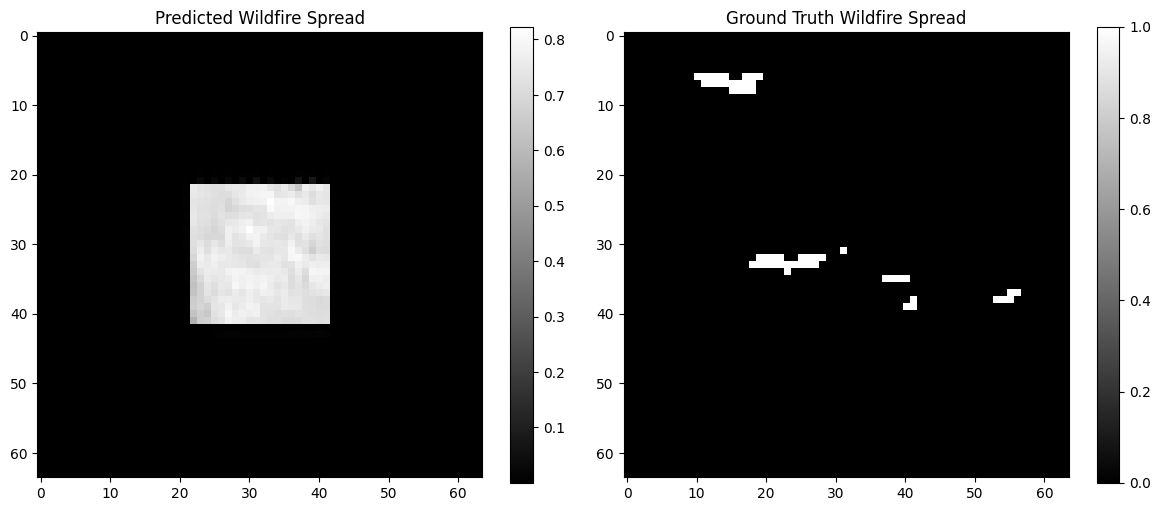

In [25]:
# Visualizating prediction on a sample test data
model.eval()
with torch.no_grad():
    inputs, targets = next(iter(test_loader))
    inputs = inputs.to(device)
    outputs = model(inputs)
    outputs = outputs.cpu().numpy()
    targets = targets.cpu().numpy()

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(outputs[0,0], cmap="gray")
plt.title("Predicted Wildfire Spread")
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(targets[0,0], cmap="gray")
plt.title("Ground Truth Wildfire Spread")
plt.colorbar()
plt.tight_layout()
plt.show()

## Model 2

In [27]:
from torch.utils.data import Subset, WeightedRandomSampler

# WildfireDataset with missing data handling, random cropping and data augmentation
class WildfireDataset(Dataset):
    def __init__(self, samples, feature_info, full_size=64, crop_size=32, input_keys=None, transform=None, missing_value=-9999.0):
        self.samples = samples
        self.feature_info = feature_info
        self.full_size = full_size
        self.crop_size = crop_size
        self.transform = transform
        self.missing_value = missing_value

        if input_keys is None:
            self.input_keys = [k for k in feature_info.keys() if k != "FireMask"]
        else:
            self.input_keys = input_keys

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        record = self.samples[idx]
        channels = []
        for key in self.input_keys:
            arr = np.array(record[key], dtype=np.float32).reshape(self.full_size, self.full_size)

            # Handling missing data
            arr[arr == self.missing_value] = 0.0

            channels.append(arr[None, ...])
        x = np.concatenate(channels, axis=0)

        target_arr = np.array(record["FireMask"], dtype=np.float32).reshape(self.full_size, self.full_size)

        valid_mask = (target_arr >= 0).astype(np.float32)
        y = (target_arr > 0).astype(np.float32)
        y[valid_mask == 0] = 0.0

        y = y[None, ...] 
        valid_mask = valid_mask[None, ...] 
        
        # Applying random cropping
        if self.crop_size < self.full_size:
            top = np.random.randint(0, self.full_size - self.crop_size + 1)
            left = np.random.randint(0, self.full_size - self.crop_size + 1)

            x = x[:, top : top + self.crop_size, left : left + self.crop_size]
            y = y[:, top : top + self.crop_size, left : left + self.crop_size]
            valid_mask = valid_mask[:, top : top + self.crop_size, left : left + self.crop_size]

        x = torch.tensor(x, dtype=torch.float)
        y = torch.tensor(y, dtype=torch.float)
        valid_mask = torch.tensor(valid_mask, dtype=torch.float)

        # Applying data augmentation
        if self.transform is not None:
            x, y, valid_mask = self.transform(x, y, valid_mask)

        return x, y, valid_mask


class RandomFlipRotate:
    def __init__(self, p=0.5):
        self.p = p

    def __call__(self, x, y, valid_mask):
        # Random horizontal flip
        if np.random.rand() < self.p:
            x = torch.flip(x, dims=[2])
            y = torch.flip(y, dims=[2])
            valid_mask = torch.flip(valid_mask, dims=[2])

        # Random vertical flip
        if np.random.rand() < self.p:
            x = torch.flip(x, dims=[1])
            y = torch.flip(y, dims=[1])
            valid_mask = torch.flip(valid_mask, dims=[1])

        # Random 90-degree rotation
        k = np.random.randint(0,4)
        x = torch.rot90(x, k, dims=[1,2])
        y = torch.rot90(y, k, dims=[1,2])
        valid_mask = torch.rot90(valid_mask, k, dims=[1,2])

        # Random brightness
        if np.random.rand() < 0.3:
            factor = 1.0 + 0.1 * (2*np.random.rand() - 1)
            x = x * factor

        return x, y, valid_mask

# Custom WeightedRandomSampler for emphasizing on samples with fire
def compute_sample_weights(dataset):
    weights = []
    for i in range(len(dataset)):
        x, y, valid_mask = dataset[i]
        valid_pixels = valid_mask.sum().item()
        fire_pixels = (y * valid_mask).sum().item()
        frac_fire = fire_pixels / (valid_pixels if valid_pixels > 0 else 1.0)
        w = 1.0 + 20.0 * frac_fire
        weights.append(w)
    return weights

## Model Architecture

In [28]:
# Updated architecture of the attention U-Net model with dropout, batchnormalization and convulation layers
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, dropout_p=0.0):
        super(ConvBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2   = nn.BatchNorm2d(out_channels)
        self.relu  = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout2d(p=dropout_p)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        if self.dropout.p > 0:
            x = self.dropout(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        if self.dropout.p > 0:
            x = self.dropout(x)

        return x


# Defining attention block
class AttentionBlock(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super(AttentionBlock, self).__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )
        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi


class ImprovedAttUNet(nn.Module):
    def __init__(self, in_channels, out_channels, dropout_p=0.0):
        super(ImprovedAttUNet, self).__init__()

        # Encoder
        self.enc1 = ConvBlock(in_channels, 32, dropout_p=dropout_p)
        self.pool1 = nn.MaxPool2d(2)

        self.enc2 = ConvBlock(32, 64, dropout_p=dropout_p)
        self.pool2 = nn.MaxPool2d(2)

        # Bottleneck
        self.bottleneck = ConvBlock(64, 128, dropout_p=dropout_p)

        # Decoder
        self.up2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.att2 = AttentionBlock(F_g=64, F_l=64, F_int=32)
        self.dec2 = ConvBlock(128, 64, dropout_p=dropout_p)

        self.up1 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.att1 = AttentionBlock(F_g=32, F_l=32, F_int=16)
        self.dec1 = ConvBlock(64, 32, dropout_p=dropout_p)

        self.out_conv = nn.Conv2d(32, out_channels, kernel_size=1)

    def forward(self, x):
        # Encoder
        enc1 = self.enc1(x)                
        enc2 = self.enc2(self.pool1(enc1))

        # Bottleneck
        bottleneck = self.bottleneck(self.pool2(enc2))

        # Decoder
        dec2 = self.up2(bottleneck)
        enc2_att = self.att2(dec2, enc2)
        dec2 = torch.cat([dec2, enc2_att], dim=1)
        dec2 = self.dec2(dec2)

        dec1 = self.up1(dec2)
        enc1_att = self.att1(dec1, enc1)
        dec1 = torch.cat([dec1, enc1_att], dim=1)
        dec1 = self.dec1(dec1)

        out = self.out_conv(dec1)
        return torch.sigmoid(out)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
in_channels = len([k for k in feature_info.keys() if k != "FireMask"])
model = ImprovedAttUNet(in_channels, out_channels=1, dropout_p=0.2).to(device)
summary(model, input_size=(1, in_channels, 64, 64))

Layer (type:depth-idx)                   Output Shape              Param #
ImprovedAttUNet                          [1, 1, 64, 64]            --
├─ConvBlock: 1-1                         [1, 32, 64, 64]           --
│    └─Conv2d: 2-1                       [1, 32, 64, 64]           3,488
│    └─BatchNorm2d: 2-2                  [1, 32, 64, 64]           64
│    └─ReLU: 2-3                         [1, 32, 64, 64]           --
│    └─Dropout2d: 2-4                    [1, 32, 64, 64]           --
│    └─Conv2d: 2-5                       [1, 32, 64, 64]           9,248
│    └─BatchNorm2d: 2-6                  [1, 32, 64, 64]           64
│    └─ReLU: 2-7                         [1, 32, 64, 64]           --
│    └─Dropout2d: 2-8                    [1, 32, 64, 64]           --
├─MaxPool2d: 1-2                         [1, 32, 32, 32]           --
├─ConvBlock: 1-3                         [1, 64, 32, 32]           --
│    └─Conv2d: 2-9                       [1, 64, 32, 32]           18,496
│    

In [29]:
# FocalTverskyLoss for handling imbalance data
class FocalTverskyLoss(nn.Module):

    def __init__(self, alpha=0.7, beta=0.3, gamma=0.75, smooth=1e-6):
        super(FocalTverskyLoss, self).__init__()
        self.alpha = alpha
        self.beta  = beta
        self.gamma = gamma
        self.smooth = smooth

    def forward(self, inputs, targets, valid_mask=None):
        if valid_mask is None:
            valid_mask = torch.ones_like(targets)

        # Flatten
        inputs_flat = inputs.view(-1)
        targets_flat = targets.view(-1)
        valid_mask_flat = valid_mask.view(-1)

        # Considering only valid pixels
        inputs_flat = inputs_flat  * valid_mask_flat
        targets_flat = targets_flat * valid_mask_flat

        # Computing Tversky
        TP = (inputs_flat * targets_flat).sum()
        FN = ((1 - inputs_flat) * targets_flat).sum()
        FP = (inputs_flat * (1 - targets_flat)).sum()

        tversky_index = (TP + self.smooth) / (TP + self.alpha*FN + self.beta*FP + self.smooth)
        focal_tversky = (1.0 - tversky_index) ** self.gamma
        return focal_tversky

In [30]:
# Functions to calculate the precision, recall and f1
def compute_precision(pred, target, valid_mask, threshold=0.5):
    pred_bin = (pred > threshold).float()
    TP = ((pred_bin * target) * valid_mask).sum()
    FP = ((pred_bin * (1 - target)) * valid_mask).sum()
    precision = (TP + 1e-6) / (TP + FP + 1e-6)
    return precision

def compute_recall(pred, target, valid_mask, threshold=0.5):
    pred_bin = (pred > threshold).float()
    TP = ((pred_bin * target) * valid_mask).sum()
    FN = (((1 - pred_bin) * target) * valid_mask).sum()
    recall = (TP + 1e-6) / (TP + FN + 1e-6)
    return recall

def compute_f1(pred, target, valid_mask, threshold=0.5):
    prec = compute_precision(pred, target, valid_mask, threshold)
    rec = compute_recall(pred, target, valid_mask, threshold)
    return 2 * (prec * rec) / (prec + rec + 1e-6)

In [31]:
full_dataset = WildfireDataset(samples=all_samples, feature_info=feature_info, full_size=64, crop_size=32, input_keys=None, transform=None, missing_value=-9999.0)

indices = list(range(len(full_dataset)))
train_val_idx, test_idx = train_test_split(indices, test_size=0.15, random_state=42)
train_idx, val_idx = train_test_split(train_val_idx, test_size=(0.15/0.85), random_state=42)

train_dataset = Subset(full_dataset, train_idx)
val_dataset = Subset(full_dataset, val_idx)
test_dataset = Subset(full_dataset, test_idx)

train_dataset.dataset.transform = RandomFlipRotate(p=0.5)

# Weighted sampling
train_weights = compute_sample_weights(train_dataset)
train_sampler = WeightedRandomSampler(train_weights, num_samples=len(train_weights), replacement=True)

batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,   num_workers=4)

criterion = FocalTverskyLoss(alpha=0.7, beta=0.3, gamma=0.75)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

In [32]:
# Training
num_epochs = 30
best_val_iou = 0.0
patience = 5
patience_counter = 0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for (x, y, valid_mask) in train_loader:
        x, y, valid_mask = x.to(device), y.to(device), valid_mask.to(device)

        optimizer.zero_grad()
        preds = model(x)
        loss = criterion(preds, y, valid_mask=valid_mask)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)

    # Validation
    model.eval()
    val_loss = 0.0
    pixel_acc = 0.0
    iou_score = 0.0
    prec = 0.0
    rec = 0.0
    f1 = 0.0

    with torch.no_grad():
        for (x, y, valid_mask) in val_loader:
            x, y, valid_mask = x.to(device), y.to(device), valid_mask.to(device)
            preds = model(x)
            loss = criterion(preds, y, valid_mask=valid_mask)
            val_loss += loss.item()
            
            pixel_acc += compute_pixel_accuracy(preds, y, valid_mask).item()
            iou_score += compute_iou(preds, y, valid_mask).item()
            prec += compute_precision(preds, y, valid_mask).item()
            rec += compute_recall(preds, y, valid_mask).item()
            f1 += compute_f1(preds, y, valid_mask).item()

    avg_val_loss = val_loss / len(val_loader)
    avg_pixel_acc = pixel_acc / len(val_loader)
    avg_iou = iou_score / len(val_loader)
    avg_prec = prec / len(val_loader)
    avg_rec = rec / len(val_loader)
    avg_f1 = f1 / len(val_loader)

    scheduler.step(avg_val_loss)

    print(f"\nEpoch [{epoch+1}/{num_epochs}]")
    print(f"Train Loss: {avg_train_loss:.4f}")
    print(f"Val Loss: {avg_val_loss:.4f}")
    print(f"Pixel Acc: {avg_pixel_acc:.4f}")
    print(f"IoU: {avg_iou:.4f}")
    print(f"Precision: {avg_prec:.4f}")
    print(f"Recall: {avg_rec:.4f}")
    print(f"F1 Score: {avg_f1:.4f}")

    # Early stopping
    if avg_iou > best_val_iou:
        best_val_iou = avg_iou
        patience_counter = 0
        torch.save(model.state_dict(), "best_model.pth")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered!")
            break


Epoch [1/30]
Train Loss: 0.8629
Val Loss: 0.9038
Pixel Acc: 0.9511
IoU: 0.0941
Precision: 0.0443
Recall: 0.7124
F1 Score: 0.0823

Epoch [2/30]
Train Loss: 0.8511
Val Loss: 0.9050
Pixel Acc: 0.9529
IoU: 0.0966
Precision: 0.0664
Recall: 0.4249
F1 Score: 0.0876

Epoch [3/30]
Train Loss: 0.8465
Val Loss: 0.8923
Pixel Acc: 0.9527
IoU: 0.0988
Precision: 0.0558
Recall: 0.6096
F1 Score: 0.0948

Epoch [4/30]
Train Loss: 0.8408
Val Loss: 0.8956
Pixel Acc: 0.9517
IoU: 0.1024
Precision: 0.0716
Recall: 0.3672
F1 Score: 0.1001

Epoch [5/30]
Train Loss: 0.8426
Val Loss: 0.9622
Pixel Acc: 0.9524
IoU: 0.0988
Precision: 0.2784
Recall: 0.0574
F1 Score: 0.0474

Epoch [6/30]
Train Loss: 0.8355
Val Loss: 0.9062
Pixel Acc: 0.9520
IoU: 0.1002
Precision: 0.1176
Recall: 0.2465
F1 Score: 0.0975

Epoch [7/30]
Train Loss: 0.8338
Val Loss: 0.8831
Pixel Acc: 0.9525
IoU: 0.0970
Precision: 0.0915
Recall: 0.3297
F1 Score: 0.1180

Epoch [8/30]
Train Loss: 0.8308
Val Loss: 0.8790
Pixel Acc: 0.9522
IoU: 0.1031
Precision:

In [33]:
# Evaluation
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

test_loss = 0.0
test_pixel_acc = 0.0
test_iou = 0.0
test_prec = 0.0
test_rec = 0.0
test_f1 = 0.0

with torch.no_grad():
    for (x, y, valid_mask) in test_loader:
        x, y, valid_mask = x.to(device), y.to(device), valid_mask.to(device)
        preds = model(x)

        loss = criterion(preds, y, valid_mask=valid_mask)
        test_loss += loss.item()

        test_pixel_acc += compute_pixel_accuracy(preds, y, valid_mask).item()
        test_iou += compute_iou(preds, y, valid_mask).item()
        test_prec += compute_precision(preds, y, valid_mask).item()
        test_rec += compute_recall(preds, y, valid_mask).item()
        test_f1 += compute_f1(preds, y, valid_mask).item()

n_test = len(test_loader)
print("\nTest Dataset")
print(f"Test Loss: {test_loss / n_test:.4f}")
print(f"Pixel Accuracy:{test_pixel_acc / n_test:.4f}")
print(f"IoU: {test_iou / n_test:.4f}")
print(f"Precision: {test_prec / n_test:.4f}")
print(f"Recall: {test_rec / n_test:.4f}")
print(f"F1 Score: {test_f1 / n_test:.4f}")

<ipython-input-33-49697cfe1a60>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))



Test Dataset
Test Loss: 0.8760
Pixel Accuracy:0.9521
IoU: 0.0903
Precision: 0.0924
Recall: 0.4644
F1 Score: 0.1164


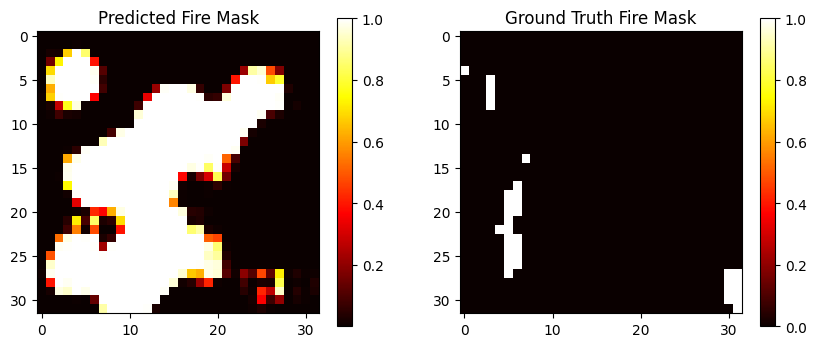

In [34]:
# Visualizing a sample from test data
inputs, targets, valid_mask = next(iter(test_loader))
inputs, targets, valid_mask = inputs.to(device), targets.to(device), valid_mask.to(device)

with torch.no_grad():
    outputs = model(inputs)
outputs_np = outputs.cpu().numpy()
targets_np = targets.cpu().numpy()

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(outputs_np[0,0], cmap='hot')
plt.title("Predicted Fire Mask")
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(targets_np[0,0], cmap='hot')
plt.title("Ground Truth Fire Mask")
plt.colorbar()
plt.show()

## Pretained model

In [35]:
!pip install segmentation_models_pytorch

In [38]:
import segmentation_models_pytorch as smp

# Loading pretrained UNet Model
def get_in_channels(feature_info):
    return len([k for k in feature_info.keys() if k != "FireMask"])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
in_channels = get_in_channels(feature_info)

# Initializing a UNet with a ResNet-34 encoder pretrained on ImageNet
model = smp.Unet(encoder_name="resnet34", encoder_weights="imagenet", in_channels=in_channels, classes=1,activation="sigmoid").to(device)

criterion = FocalTverskyLoss(alpha=0.7, beta=0.3, gamma=0.75)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

# Training
num_epochs = 30
best_val_iou = 0.0
patience = 5
patience_counter = 0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for (x, y, valid_mask) in train_loader:
        x, y, valid_mask = x.to(device), y.to(device), valid_mask.to(device)

        optimizer.zero_grad()
        preds = model(x)
        loss = criterion(preds, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)

    # Validation phase
    model.eval()
    val_loss = 0.0
    pixel_acc = 0.0
    iou_score = 0.0
    prec = 0.0
    rec = 0.0
    f1 = 0.0

    with torch.no_grad():
        for (x, y, valid_mask) in val_loader:
            x, y, valid_mask = x.to(device), y.to(device), valid_mask.to(device)
            preds = model(x)
            loss = criterion(preds, y)
            val_loss += loss.item()

            pixel_acc += compute_pixel_accuracy(preds, y, valid_mask).item()
            iou_score += compute_iou(preds, y, valid_mask).item()
            prec += compute_precision(preds, y, valid_mask).item()
            rec += compute_recall(preds, y, valid_mask).item()
            f1 += compute_f1(preds, y, valid_mask).item()

    avg_val_loss = val_loss / len(val_loader)
    avg_pixel_acc = pixel_acc / len(val_loader)
    avg_iou = iou_score / len(val_loader)
    avg_prec = prec / len(val_loader)
    avg_rec = rec / len(val_loader)
    avg_f1 = f1 / len(val_loader)

    scheduler.step(avg_val_loss)

    print(f"\nEpoch [{epoch+1}/{num_epochs}]")
    print(f"Train Loss: {avg_train_loss:.4f}")
    print(f"Val Loss: {avg_val_loss:.4f}")
    print(f"Pixel Acc: {avg_pixel_acc:.4f}")
    print(f"IoU: {avg_iou:.4f}")
    print(f"Precision: {avg_prec:.4f}")
    print(f"Recall: {avg_rec:.4f}")
    print(f"F1 Score: {avg_f1:.4f}")

    if avg_iou > best_val_iou:
        best_val_iou = avg_iou
        patience_counter = 0
        torch.save(model.state_dict(), "best_pretrained_model.pth")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered!")
            break


Epoch [1/30]
Train Loss: 0.8694
Val Loss: 0.9064
Pixel Acc: 0.9518
IoU: 0.0991
Precision: 0.0728
Recall: 0.4044
F1 Score: 0.0874

Epoch [2/30]
Train Loss: 0.8520
Val Loss: 0.9003
Pixel Acc: 0.9520
IoU: 0.0988
Precision: 0.0571
Recall: 0.4971
F1 Score: 0.0902

Epoch [3/30]
Train Loss: 0.8509
Val Loss: 0.9087
Pixel Acc: 0.9515
IoU: 0.1042
Precision: 0.1170
Recall: 0.3459
F1 Score: 0.0866

Epoch [4/30]
Train Loss: 0.8463
Val Loss: 0.9422
Pixel Acc: 0.9524
IoU: 0.1007
Precision: 0.1748
Recall: 0.1262
F1 Score: 0.0621

Epoch [5/30]
Train Loss: 0.8465
Val Loss: 0.9048
Pixel Acc: 0.9523
IoU: 0.1024
Precision: 0.0444
Recall: 0.7019
F1 Score: 0.0823

Epoch [6/30]
Train Loss: 0.8474
Val Loss: 0.8858
Pixel Acc: 0.9517
IoU: 0.0995
Precision: 0.0806
Recall: 0.4380
F1 Score: 0.1063

Epoch [7/30]
Train Loss: 0.8415
Val Loss: 0.8844
Pixel Acc: 0.9529
IoU: 0.0973
Precision: 0.0859
Recall: 0.4640
F1 Score: 0.1069

Epoch [8/30]
Train Loss: 0.8368
Val Loss: 0.8978
Pixel Acc: 0.9531
IoU: 0.0984
Precision:

In [39]:
# Evaluation
model.load_state_dict(torch.load("best_pretrained_model.pth"))
model.eval()
test_loss = 0.0
test_pixel_acc = 0.0
test_iou = 0.0
test_prec = 0.0
test_rec = 0.0
test_f1 = 0.0

with torch.no_grad():
    for (x, y, valid_mask) in test_loader:
        x, y, valid_mask = x.to(device), y.to(device), valid_mask.to(device)
        preds = model(x)
        loss = criterion(preds, y)
        test_loss += loss.item()

        test_pixel_acc += compute_pixel_accuracy(preds, y, valid_mask).item()
        test_iou += compute_iou(preds, y, valid_mask).item()
        test_prec += compute_precision(preds, y, valid_mask).item()
        test_rec += compute_recall(preds, y, valid_mask).item()
        test_f1 += compute_f1(preds, y, valid_mask).item()

n_test = len(test_loader)
print("\nEvaluation on Test Dataset")
print(f"Test Loss: {test_loss / n_test:.4f}")
print(f"Pixel Accuracy: {test_pixel_acc / n_test:.4f}")
print(f"IoU: {test_iou / n_test:.4f}")
print(f"Precision: {test_prec / n_test:.4f}")
print(f"Recall: {test_rec / n_test:.4f}")
print(f"F1 Score: {test_f1 / n_test:.4f}")

<ipython-input-39-c286d43d822c>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_pretrained_model.pth"))



Evaluation on Test Dataset
Test Loss: 0.9014
Pixel Accuracy: 0.9529
IoU: 0.0896
Precision: 0.1438
Recall: 0.3643
F1 Score: 0.0935


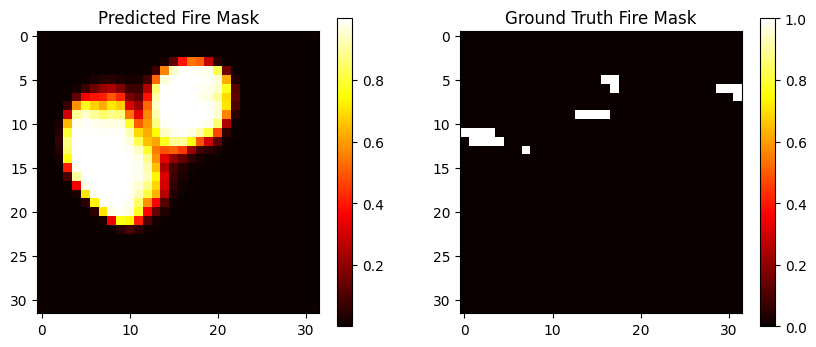

In [40]:
# Visualize Prediction on one sample from test
inputs, targets, valid_mask = next(iter(test_loader))
inputs, targets, valid_mask = inputs.to(device), targets.to(device), valid_mask.to(device)

with torch.no_grad():
    outputs = model(inputs)
outputs_np = outputs.cpu().numpy()
targets_np = targets.cpu().numpy()

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(outputs_np[0,0], cmap='hot')
plt.title("Predicted Fire Mask")
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(targets_np[0,0], cmap='hot')
plt.title("Ground Truth Fire Mask")
plt.colorbar()
plt.show()

### References

- https://www.kaggle.com/datasets/fantineh/next-day-wildfire-spread
- https://www.tensorflow.org/tutorials/load_data/tfrecord
- https://arxiv.org/pdf/2112.02447
- https://github.com/dwgb93/TEI_WildfireSpread/
- https://smp.readthedocs.io/en/latest/
- https://smp.readthedocs.io/en/latest/models.html#id21
- https://medium.com/@nghihuynh_37300/understanding-evaluation-metrics-in-medical-image-segmentation-d289a373a3f
- https://pytorch.org/tutorials/beginner/data_loading_tutorial.html
- https://medium.com/data-scientists-diary/implementing-focal-loss-in-pytorch-for-class-imbalance-24d8aa3b59d9
- https://medium.com/data-scientists-diary/implementation-of-dice-loss-vision-pytorch-7eef1e438f68
- https://www.kaggle.com/code/bigironsphere/loss-function-library-keras-pytorch#Tversky-Loss